<a href="https://colab.research.google.com/github/VinolFernandes/SaveSoilSentiment/blob/main/xyz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tweet-preprocessor


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.2 MB/s 
     |████████████████████████████████| 86 kB 6.6 MB/s 
     |████████████████████████████████| 596 kB 59.2 MB/s 
     |████████████████████████████████| 6.6 MB 45.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# **Importing necessary librares:**

In [3]:
import re
import seaborn as sns
from textblob import TextBlob
import tweepy,json
import configparser
import pandas as pd
import nltk
import preprocessor as p
from gensim.parsing.preprocessing import remove_stopwords
from wordcloud import WordCloud
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import urllib
import csv
import numpy as np
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report


from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


In [4]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# **Twitter authentication:**

In [5]:
# read configs
# config = configparser.ConfigParser()
# config.read('config.ini')

api_key = "JznrffZJswnMlduJPCkH93dLB"
api_key_secret ="UqSGA8Rj7mdMQq4V3W4kNU4afgE7Yqe5qrTdUVPhuWELLDTqxr"

access_token = "1304455384304762880-L7ejEdH4YazBoFAvV8xJaN2E9M7oNE"
access_token_secret = "wv0BZpQCHBC51Qqit3NQgsJiPOu5qhrxHVk62syuZQEW8"

# authentication
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)


# **Extracting Data, based on keywords:**

In [6]:

# user tweets
# user = 'veritasium'
# limit=300

# tweets = tweepy.Cursor(api.user_timeline, screen_name=user, count=200, tweet_mode='extended').items(limit)

# search tweets
keywords = '#savesoil'
limit=1000

tweets = tweepy.Cursor(api.search, q=keywords, count=100, tweet_mode='extended' ).items(limit)
print(tweets)
# tweets = api.user_timeline(screen_name=user, count=limit, tweet_mode='extended')

# create DataFrame
columns = ['User', 'Tweet','Source','Verified','Location','Language','Class']
data = []

polarity = 0.0
positive = 0.0
negative = 0.0
neutral = 0.0

for tweet in tweets:
    analysis = TextBlob(tweet.full_text) 
    tweet_polarity = analysis.polarity 
    # data.append([tweet.user.screen_name, tweet.full_text,tweet.source,tweet.user.verified,tweet.user.location,tweet.lang,'POSITIVE'])
    # print(data[:2])
    
    if tweet_polarity > 0:
        positive += 1 
        data.append([tweet.user.screen_name, tweet.full_text,tweet.source,tweet.user.verified,tweet.user.location,tweet.lang,'POSITIVE'])
        #print('pos')
    elif tweet_polarity < 0 :
        negative +=1
        data.append([tweet.user.screen_name, tweet.full_text,tweet.source,tweet.user.verified,tweet.user.location,tweet.lang,'NEGATIVE'])
        #print('neg')
    else:
        neutral +=1
        data.append([tweet.user.screen_name, tweet.full_text,tweet.source,tweet.user.verified,tweet.user.location,tweet.lang,'NEUTRAL'])
        #print('neu')
    polarity += analysis.polarity

    

# create dataframe
   
print(polarity)
print(f'Amount of Positive tweets: {positive}')
print(f'Amount of Negative tweets: {negative}')
print(f'Amount of Neutral tweets: {neutral}')    

df = pd.DataFrame(data, columns=columns)

print(df)
df1=df["Tweet"]


236.8703639069263
Amount of Positive tweets: 514.0
Amount of Negative tweets: 31.0
Amount of Neutral tweets: 455.0
                User                                              Tweet  \
0     AnneMCosgrove2  RT @BhooMangalaaka1: Adiyogi awaits ... 🙇‍♀️🙇‍...   
1          s1deepnag  #SaveSoil #JourneyForSoil #ConsciousPlanet @Sa...   
2        Pradhyumn_S                  #SaveSoil https://t.co/Whgvy0jSnc   
3         VenkatArra  RT @SadhguruJV: Truly wonderful to see Gujarat...   
4        gforgovindu  RT @Ksareen30: All PVR Cinemas across India wi...   
..               ...                                                ...   
995     SaveSoilApac  No matter how much wealth, education, and mone...   
996   CiprianaSimons  RT @SadhguruJV: Bharat- her rich soil made her...   
997        limsansan  Commenting on the the diversity of cover soil ...   
998  GeetGup37328820  Save soil. Lets make it happen. #SaveSoilWave\...   
999       ReetuKapur  RT @Pallavi84575641: @HindiSadhguru मन

# **Cleaning data:**

In [7]:
def preprocess_tweet(row):
    text = row['Tweet']
    text = p.clean(text)
    return text

def stopword_removal(row):
    text = row['Tweet']
    text = remove_stopwords(text)
    return text

df['Tweet']=df.apply(preprocess_tweet,axis=1)
# print(df)   
df['Tweet'] = df.apply(stopword_removal, axis=1)


df['Tweet'] = df['Tweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')
# print(df)

tweet_string_list = df['Tweet'].tolist()
tweet_string = ' '.join(tweet_string_list)
print(df)

                User                                              Tweet  \
0     AnneMCosgrove2                                    adiyogi awaits    
1          s1deepnag                                                      
2        Pradhyumn_S                                                      
3         VenkatArra   truly wonderful gujarat taking lead may memor...   
4        gforgovindu          all pvr cinemas india video played movie    
..               ...                                                ...   
995     SaveSoilApac  no matter wealth education money have children...   
996   CiprianaSimons   bharat rich soil shining jewel crown cultures...   
997        limsansan  commenting diversity cover soil climate claire...   
998  GeetGup37328820                    save soil lets happen sadhguru    
999       ReetuKapur                                                      

                       Source  Verified                Location Language  \
0             Twitter W

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  app.launch_new_instance()


# **Classification of tweets: Positive, Neutral,Negative**

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

['negative', 'neutral', 'positive']


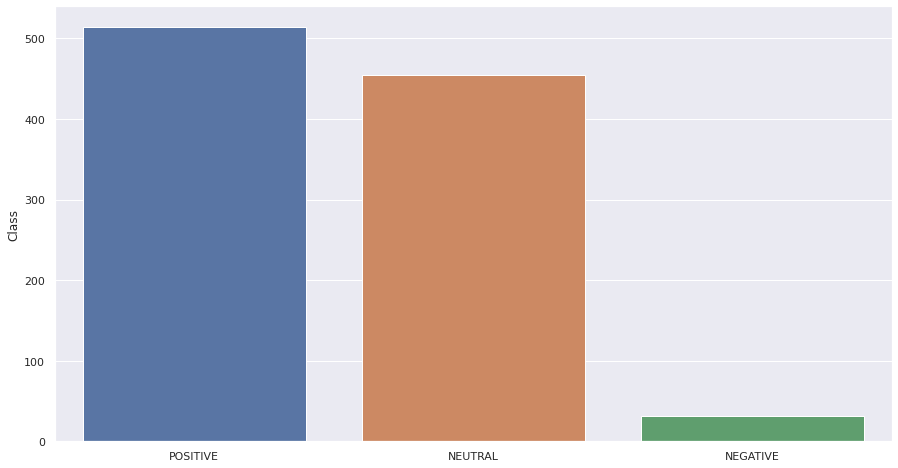

In [8]:

device = "cuda:0" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment").to(device)

labels=[]
task = 'sentiment'
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]
print(labels)


sns.set(rc={'figure.figsize':(15,8)})

sns.barplot(x=df.Class.value_counts().index,y=df.Class.value_counts())

In [9]:

from scipy.special import softmax
BATCH_SIZE = 10
sentiment_df=df
scores_all = np.empty((0,len(labels)))
text_all = sentiment_df['Tweet'].to_list()
n = len(text_all)
with torch.no_grad():
    for start_idx in range(0, n, BATCH_SIZE):
        end_idx = min(start_idx+BATCH_SIZE, n)
        encoded_input = tokenizer(text_all[start_idx:end_idx], return_tensors='pt', padding=True, max_length=512,truncation=True).to(device)
        output = model(**encoded_input)
        scores = output[0].detach().cpu().numpy()
        scores = softmax(scores, axis=1)
        scores_all = np.concatenate((scores_all, scores), axis=0)

        del encoded_input, output, scores
        torch.cuda.empty_cache()
    


Downloading:   0%|          | 0.00/768 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

                User                                              Tweet  \
0     AnneMCosgrove2                                    adiyogi awaits    
1          s1deepnag                                                      
2        Pradhyumn_S                                                      
3         VenkatArra   truly wonderful gujarat taking lead may memor...   
4        gforgovindu          all pvr cinemas india video played movie    
..               ...                                                ...   
995     SaveSoilApac  no matter wealth education money have children...   
996   CiprianaSimons   bharat rich soil shining jewel crown cultures...   
997        limsansan  commenting diversity cover soil climate claire...   
998  GeetGup37328820                    save soil lets happen sadhguru    
999       ReetuKapur                                                      

                       Source  Verified                Location Language  \
0             Twitter W

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to b

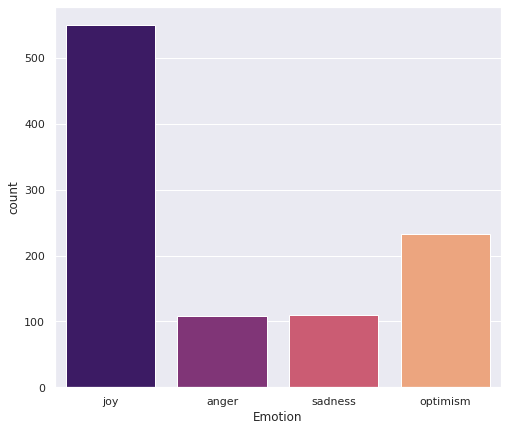

In [10]:
sentiment_df[labels] = pd.DataFrame(scores_all, columns=labels)
#print(sentiment_df)

from textblob import TextBlob
def get_sentiment(tweet):
    sentiment = TextBlob(tweet).sentiment
    return sentiment.polarity, sentiment.subjectivity

sentiment_df['sentiment'] = sentiment_df['Tweet'].apply(get_sentiment)
sentiment_df['polarity'] = sentiment_df['sentiment'].apply(lambda x:x[0])
sentiment_df['subjectivity'] = sentiment_df['sentiment'].apply(lambda x:x[0])
sentiment_df.drop('sentiment', axis=1, inplace=True)

emotion_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
emotion_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion").to(device)
task='emotion'
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]
BATCH_SIZE = 10


# print(emotion_df)


scores_all = np.empty((0,len(labels)))
text_all = sentiment_df['Tweet'].to_list()
n = len(text_all)
with torch.no_grad():
    for start_idx in range(0, n, BATCH_SIZE):
        end_idx = min(start_idx+BATCH_SIZE, n)
        encoded_input = tokenizer(text_all[start_idx:end_idx], return_tensors='pt', padding=True, max_length=512,truncation=True).to(device)
        output = emotion_model(**encoded_input)
        scores = output[0].detach().cpu().numpy()
        scores = softmax(scores, axis=1)
        scores_all = np.concatenate((scores_all, scores), axis=0)
        del encoded_input, output, scores
        torch.cuda.empty_cache()
    
sentiment_df[labels] = pd.DataFrame(scores_all, columns=labels)
print(sentiment_df)
emotion_df=sentiment_df
emotion_df.drop(['polarity','subjectivity'], axis=1, inplace=True)
emotion_df.insert(7, "Emotion", '')
for i in range(len(emotion_df)):
  if emotion_df['anger'][i] > emotion_df['joy'][i] and emotion_df['anger'][i] > emotion_df['optimism'][i] and emotion_df['anger'][i] > emotion_df['sadness'][i]:
    emotion_df['Emotion'][i] = 'anger'
  elif emotion_df['joy'][i] > emotion_df['anger'][i] and emotion_df['joy'][i] > emotion_df['optimism'][i] and emotion_df['joy'][i] > emotion_df['sadness'][i]:
    emotion_df['Emotion'][i]= 'joy'
  elif emotion_df['optimism'][i] > emotion_df['anger'][i] and emotion_df['optimism'][i] > emotion_df['joy'][i] and emotion_df['optimism'][i] > emotion_df['sadness'][i]:
    emotion_df['Emotion'][i]= 'optimism'
  else:
    emotion_df['Emotion'][i] = 'sadness'

emotion_df.drop(['anger','joy','optimism','sadness'], axis=1, inplace=True)
#graph
import seaborn as sns
import matplotlib.pyplot as plt 
plt.figure(figsize = (8,7))
sns.countplot(x="Emotion", data=emotion_df, palette='magma')

In [11]:

def preprocess(textdata):
    processedText = []
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    for tweet in textdata:
        tweetwords = ''
        for word in tweet.split():
             # Checking if the word is a stopword.
             #if word not in stopwordlist:
             if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

#Accuracy and Confusion Matrix
processedtext = preprocess(emotion_df['Tweet'])
dataset = emotion_df[['Emotion','Tweet']]
text, emotion = list(dataset['Tweet']), list(dataset['Emotion'])
X_train, X_test, y_train, y_test = train_test_split(processedtext, emotion,test_size = 0.05, random_state = 0)
print(f'Data Split done.')
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Split done.
Vectoriser fitted.
No. of feature_words:  3341
Data Transformed.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# **BernoulliNB:**

In [12]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
ys_predict = BNBmodel.predict(X_test)
print('\n\nBernoulli Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))



Bernoulli Classification Report: 
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00         6
         joy       0.64      1.00      0.78        29
    optimism       1.00      0.33      0.50        12
     sadness       1.00      0.33      0.50         3

    accuracy                           0.68        50
   macro avg       0.66      0.42      0.45        50
weighted avg       0.67      0.68      0.60        50

Confusion Matrix: 
 [[ 0  6  0  0]
 [ 0 29  0  0]
 [ 0  8  4  0]
 [ 0  2  0  1]]
Accuracy Score: 
 0.68


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
KNNModel = KNeighborsClassifier(n_neighbors=5)
KNNModel.fit(X_train, y_train)
ys_predict = KNNModel.predict(X_test)
print('\n\nKNN Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))



KNN Classification Report: 
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00         6
         joy       0.74      0.86      0.79        29
    optimism       1.00      0.33      0.50        12
     sadness       1.00      0.33      0.50         3

    accuracy                           0.60        50
   macro avg       0.68      0.38      0.45        50
weighted avg       0.73      0.60      0.61        50

Confusion Matrix: 
 [[ 0  6  0  0]
 [ 4 25  0  0]
 [ 6  2  4  0]
 [ 1  1  0  1]]
Accuracy Score: 
 0.6


In [14]:

DTCModel = DecisionTreeClassifier(random_state=0)
DTCModel.fit(X_train, y_train)
ys_predict = DTCModel.predict(X_test)
print('\n\nDecision Tree Classification Report: \n',metrics.classification_report(y_test, ys_predict))
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, ys_predict))
print('Accuracy Score: \n',metrics.accuracy_score(y_test, ys_predict))



Decision Tree Classification Report: 
               precision    recall  f1-score   support

       anger       0.43      1.00      0.60         6
         joy       0.90      0.62      0.73        29
    optimism       0.75      0.75      0.75        12
     sadness       0.75      1.00      0.86         3

    accuracy                           0.72        50
   macro avg       0.71      0.84      0.74        50
weighted avg       0.80      0.72      0.73        50

Confusion Matrix: 
 [[ 6  0  0  0]
 [ 8 18  3  0]
 [ 0  2  9  1]
 [ 0  0  0  3]]
Accuracy Score: 
 0.72


# **Plotting Wordcloud:**

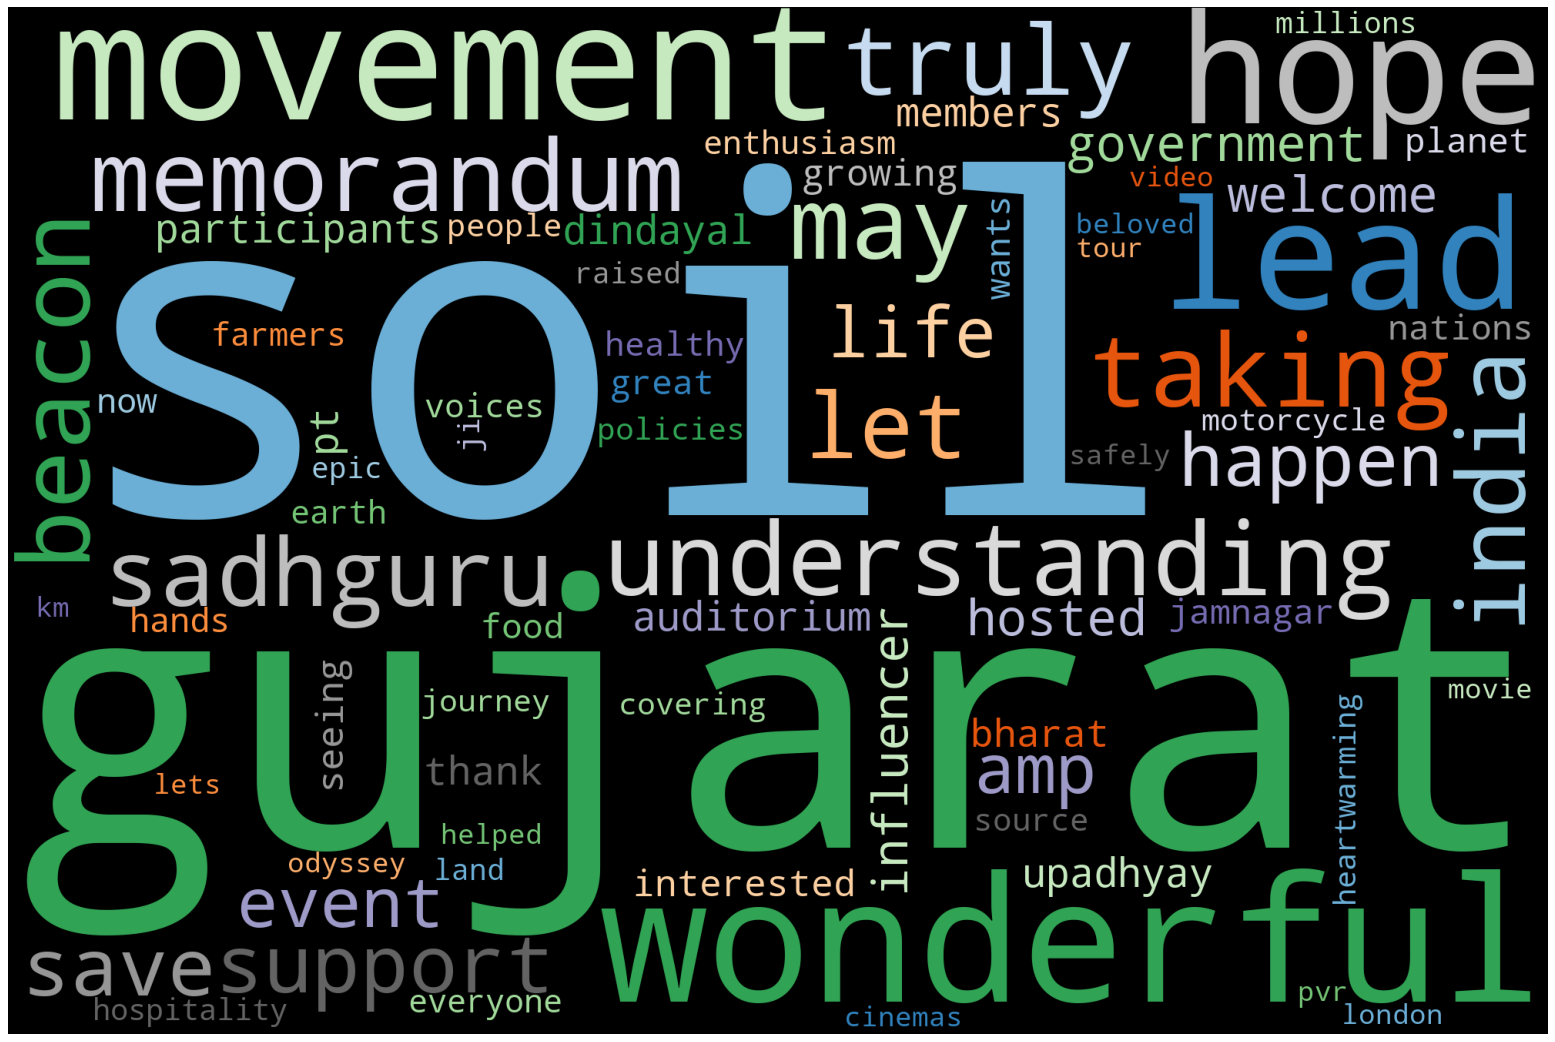

Index(['User', 'Tweet', 'Source', 'Verified', 'Location', 'Language', 'Class',
       'Emotion', 'negative', 'neutral', 'positive'],
      dtype='object')

In [15]:
wordcloud = WordCloud(width = 2000, height = 1334, random_state=1, background_color='black', colormap='tab20c', max_words = 75, collocations=False, normalize_plurals=False).generate(tweet_string)

# df.info()

import matplotlib.pyplot as plt   # for wordclouds & charts
from matplotlib.pyplot import figure

# Define a function to plot word cloud
def plot_cloud(wordcloud):
    fig = plt.figure(figsize=(25, 17), dpi=80)
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.box(False)
    plt.show()
    plt.close() 

plot_cloud(wordcloud)

df1.to_csv('tweet.csv', sep = ';', line_terminator = '', encoding = 'utf-8')
df.columns

# **Number of Tweets Based on Region**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

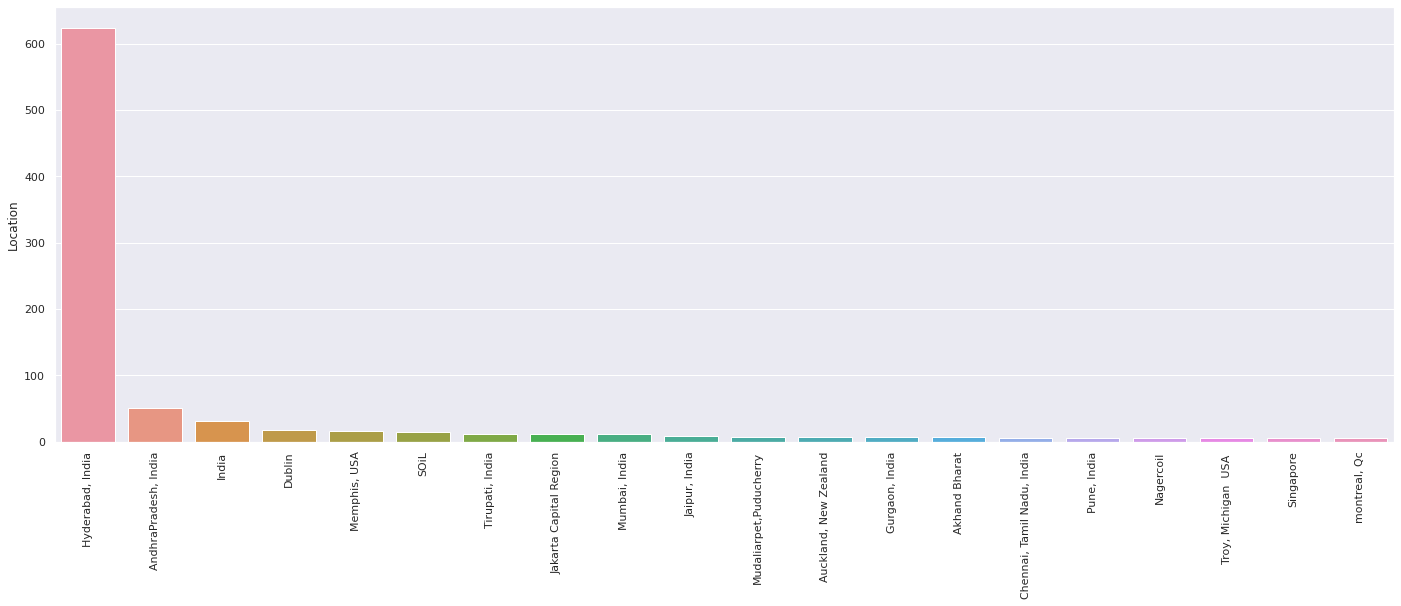

In [16]:
sns.set(rc={'figure.figsize':(24,8)})
sns.barplot(x=df.Location.value_counts()[1:21].index,y=df.Location.value_counts()[:20])
plt.xticks(rotation=90)


# **Source of Tweets:**

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

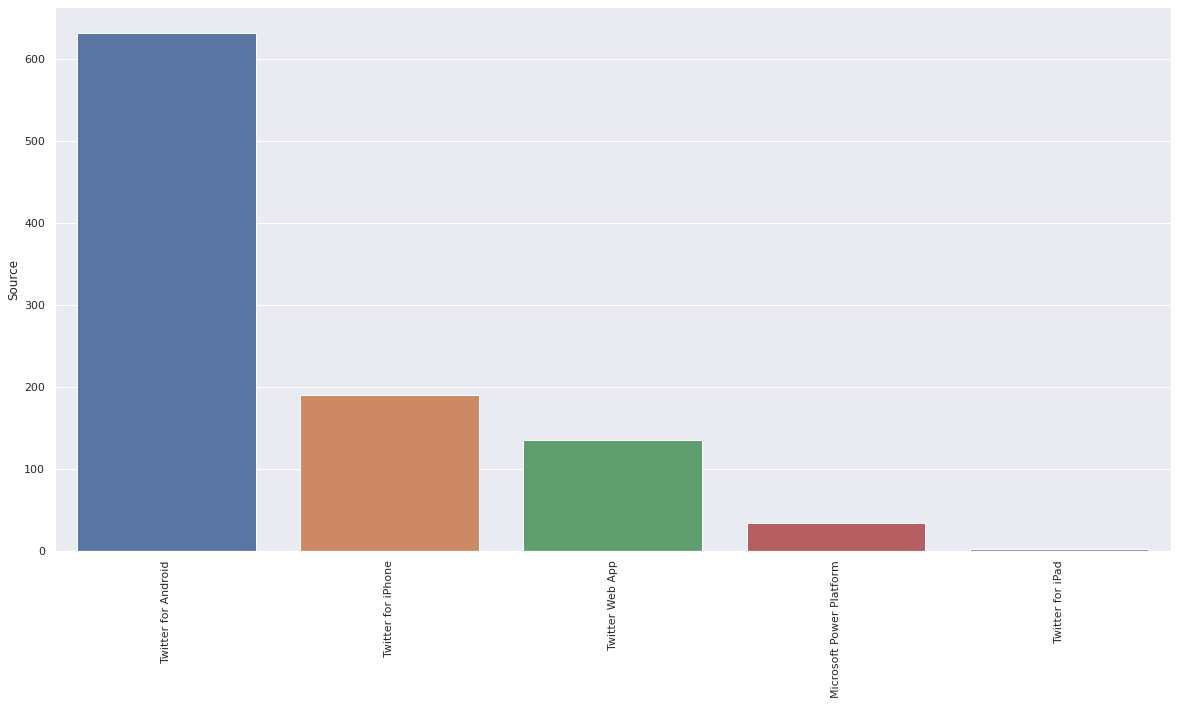

In [17]:
df.Source.value_counts()
sns.set(rc={'figure.figsize':(20,10)})

sns.barplot(x=df.Source.value_counts()[:5].index,y=df.Source.value_counts()[:5])
plt.xticks(rotation=90)


# **Verified v/s Normal Tweets:**

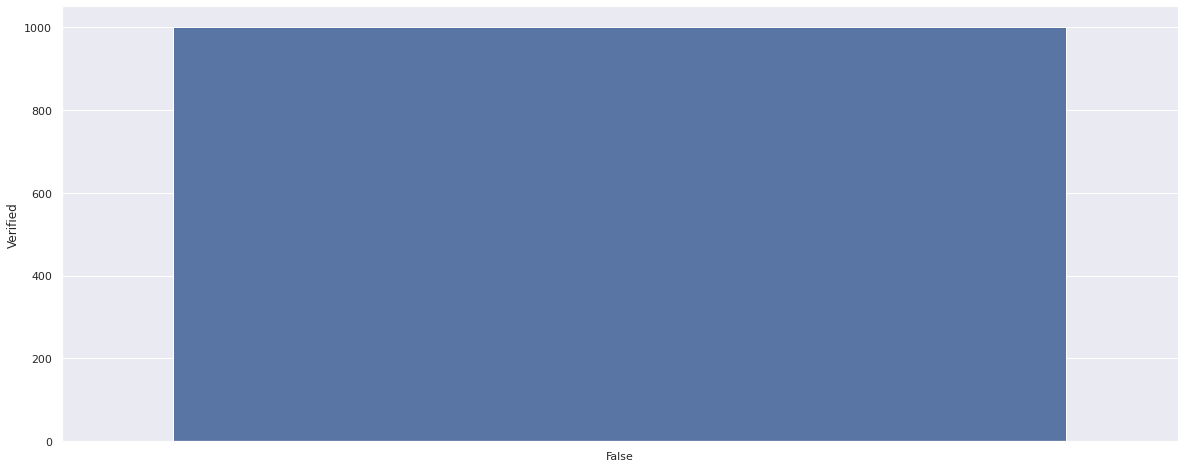

In [18]:
df.Verified.value_counts()
sns.set(rc={'figure.figsize':(20,8)})

sns.barplot(x=df.Verified.value_counts()[:5].index,y=df.Verified.value_counts()[:5])


# **Number of tweets based on languages:**

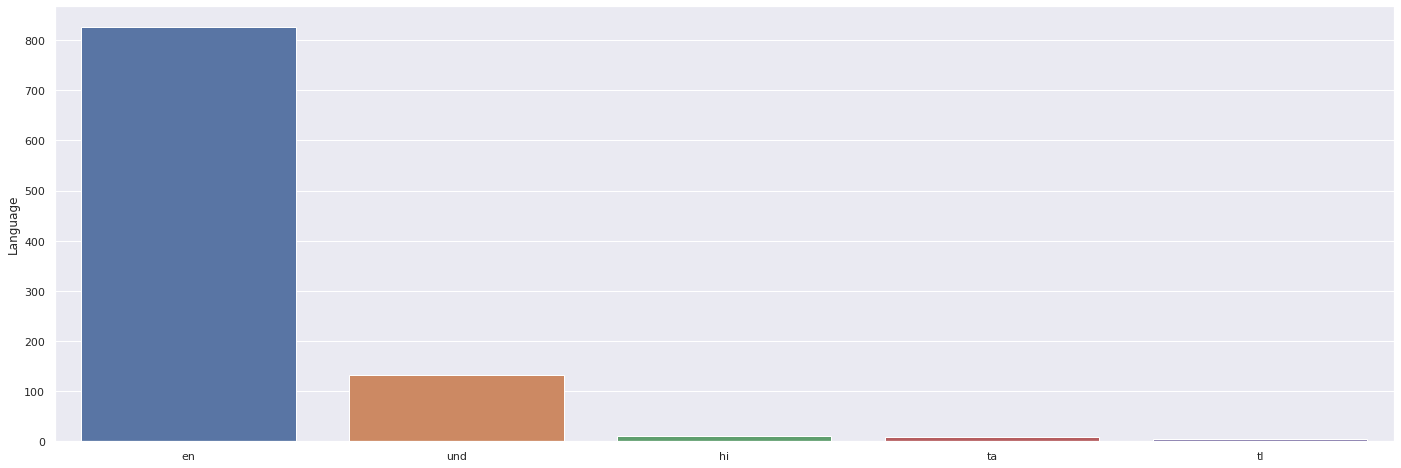

In [19]:
df.Language.value_counts()
sns.set(rc={'figure.figsize':(24,8)})

sns.barplot(x=df.Language.value_counts()[:5].index,y=df.Language.value_counts()[:5])